In [50]:


import numpy as np
import pandas as pd



In [51]:
df=pd.read_csv('data.csv')

In [52]:
print(df.head(5))
print(df.shape)

df.drop_duplicates(inplace=True)

print(df.shape)
df.rename(columns={'clean_text':'text','is_depression':'test'},inplace=True)


                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1
(7731, 2)
(7650, 2)


In [53]:
df.drop_duplicates(inplace=True)


In [54]:
df.rename(columns={'clean_text':'text','is_depression':'test'},inplace=True)

In [55]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rake_nltk import Rake
import string



# Tokenization
df['tokenized_text'] = df['text'].apply(word_tokenize)

# Lowercase conversion
df['lowercase_text'] = df['tokenized_text'].apply(lambda x: [word.lower() for word in x])

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['filtered_text'] = df['lowercase_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Keyword extraction using RAKE
r = Rake()
df['keywords'] = df['text'].apply(lambda x: r.extract_keywords_from_text(x))
df['keywords'] = df['text'].apply(lambda x: r.get_ranked_phrases())

# Lemmatization (optional)
# Lemmatization reduces words to their base or root form (e.g., "running" becomes "run")
# It's optional and depends on your specific use case
# lemmatizer = WordNetLemmatizer()
# df['lemmatized_text'] = df['filtered_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Print the DataFrame with preprocessing results
print(df)


                                                   text  test  \
0     we understand that most people who reply immed...     1   
1     welcome to r depression s check in post a plac...     1   
2     anyone else instead of sleeping more when depr...     1   
3     i ve kind of stuffed around a lot in my life d...     1   
4     sleep is my greatest and most comforting escap...     1   
...                                                 ...   ...   
7726                                       is that snow     0   
7727                 moulin rouge mad me cry once again     0   
7728  trying to shout but can t find people on the list     0   
7729  ughh can t find my red sox hat got ta wear thi...     0   
7730  slept wonderfully finally tried swatching for ...     0   

                                         tokenized_text  \
0     [we, understand, that, most, people, who, repl...   
1     [welcome, to, r, depression, s, check, in, pos...   
2     [anyone, else, instead, of, sleeping

In [56]:
print(df.columns)

Index(['text', 'test', 'tokenized_text', 'lowercase_text', 'filtered_text',
       'keywords'],
      dtype='object')


In [57]:
len(df['tokenized_text'][0])


813

In [47]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import chain

# Flatten the lists of tokenized text for Word2Vec training
tokenized_text_flat = list(chain.from_iterable(df['tokenized_text']))

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text_flat, vector_size=100, window=5, min_count=1, workers=4)

# Convert each document into a vector representation
def document_vector(word2vec_model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if len(doc) != 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply Word2Vec on tokenized text
df['word2vec_vectors'] = df['tokenized_text'].apply(lambda x: document_vector(word2vec_model, x))

# Split the data into training and testing sets
X = np.vstack(df['word2vec_vectors'].values)
y = df['test']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8104575163398693


In [58]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from itertools import chain

# Flatten the lists of tokenized text for Word2Vec training
tokenized_text_flat = list(chain.from_iterable(df['tokenized_text']))

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text_flat, vector_size=100, window=5, min_count=1, workers=4)

# Convert each document into a vector representation
def document_vector(word2vec_model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if len(doc) != 0:
        return np.mean(word2vec_model.wv[doc], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply Word2Vec on tokenized text
df['word2vec_vectors'] = df['tokenized_text'].apply(lambda x: document_vector(word2vec_model, x))

# Split the data into training and testing sets
X = np.vstack(df['word2vec_vectors'].values)
y = df['test']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

# Train the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = best_rf_classifier.score(X_test, y_test)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.8111111111111111


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Predict labels for test data
y_pred = best_rf_classifier.predict(X_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print precision, recall, and F1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


Precision: 0.8245194418986519
Recall: 0.8111111111111111
F1 Score: 0.8089437001523854

Confusion Matrix:
[[705  66]
 [223 536]]


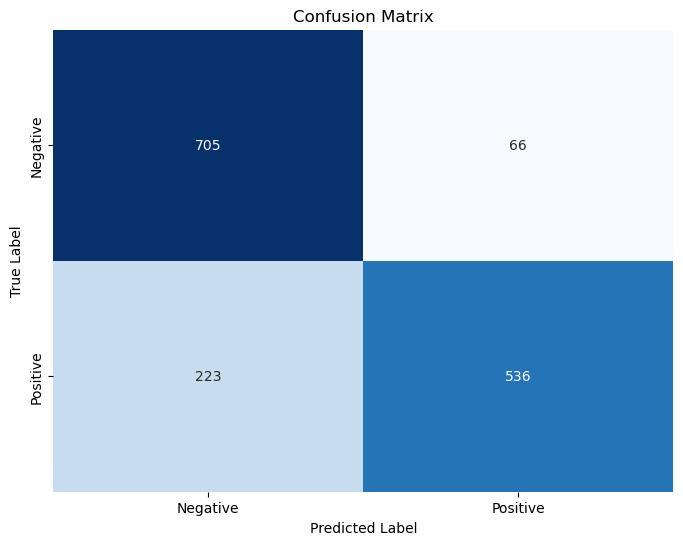

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
